# Getting some heatwave statistics

Here, heatwaves will be calculated and compared

In [1]:
import valenspy as vp
from valenspy._utilities import load_yml
from valenspy.processing.select import select_point
from valenspy.diagnostic.functions import mean_bias, mean_absolute_error, root_mean_square_error, spearman_correlation, perkins_skill_score, time_series_spatial_mean
from valenspy.diagnostic.visualizations import plot_time_series, plot_map
from pathlib import Path

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import percentileofscore
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import math

# define machine name - used for paths of (observational) datasets
machine = 'hortense'

manager = vp.InputManager(machine=machine)


## Predefining settings

In [2]:
# Define reference datasets
reference = 'ERA5'
domain = 'BE28'
model = "CCLM"

experiment = 'ERA5'
#experiment = "CB2_CCLM_BEL28_ERA5_evaluation"
rotated_pole = False

variable = "tas"
frequency = "daily"
freq_statistic = "max"
statistics = ["mean", "min", "max"]
begin_year = 1982
end_year = 2023

In [3]:
d_point_coords = {
    'opwijk'    : (4.18, 50.97), 
    'betrix'    : (5.25, 49.854),
    'north_sea' : (2.465, 51.63),
    'channel'   : (-1.05, 50.14),
    'uccle'     :(4.35, 50.80)
}
study_loc = "opwijk"

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


## Functions to detect extremes

In [4]:
def get_extreme_days(dataarray, variable, x = 20):
    """
    Get the x most extreme days from an xarray DataArray containing daily temperatures.

    Parameters:
    dataarray (xarray.DataArray): An xarray DataArray with a 'time' dimension and temperature values.

    Returns:
    list: A list of tuples with the date and corresponding temperature for the x most extreme days.
    """
    if 'time' not in dataarray.dims:
        raise ValueError("The input DataArray must have a 'time' dimension.")

    x = x*2
    # Ensure the time coordinate is of datetime type
    dataarray['time'] = pd.to_datetime(dataarray['time'].values)

    # Convert to a pandas DataFrame for easy sorting
    df = dataarray.to_dataframe().reset_index()

    # Sort the DataFrame by variable in descending order
    sorted_df = df.sort_values(by=variable, ascending=False)

    # Extract the top x extreme days
    top_x = sorted_df.head(x)

    # Return as a dataframe (time, variable, date)
    top_x = top_x[["time", variable]]
    top_x["date"] = top_x['time'].dt.date
    top_x = top_x.drop_duplicates().reset_index(drop = True)

    
    return top_x

In [5]:
def highlight_extremes(da_serie: xr.DataArray, variable: str, x : int): 

    """
    Plots the yearly cycle for each year in a timesetie dataset (`da_point`), while highlighting the extreme moments,
    starting on January 1st for all.

    Parameters:
        da_serie (xarray.Dataset): Evaluation dataset with multiple years.
        variable (str): The name of the variable to plot.
        x : number of highest values that should be shown

    Returns:
        None: Displays the plot.
    """
    plt.figure(figsize = (20,6))
    
    top_x = get_extreme_days(da_serie, variable, x)

    top_x["doy"] = pd.to_datetime(top_x["date"]).dt.dayofyear
    top_x["year"] = pd.to_datetime(top_x["date"]).dt.year
    top_x = top_x.sort_values(by = "date")

    cmap = plt.cm.Reds
    norm = Normalize(vmin=top_x[variable].min(), vmax=top_x[variable].max())
    colors = cmap(norm(top_x[variable]))

    # Exctract unique years
    years_eval = np.unique(pd.to_datetime(da_serie.time).year)
   
    # # Loop over all years:
    for yr in years_eval:
        ds_year = da_serie.sel(time=da_serie.time.dt.year.isin([yr]))
        print("In year " + str(yr) + ' we have ' + str(len(ds_year["time"])) + " datapoints.")
        if isinstance(ds_year, xr.Dataset):
            da_year = ds_year[variable]
        else:
            da_year = ds_year
        df_year = da_year
        da_year["doy"] = da_year['time'].dt.dayofyear

        plt.plot(da_year['doy'], da_year, color = "grey")

        indices = np.where(top_x["year"] == yr)[0]
        if indices.size > 0:
            top_year = top_x.iloc[indices]
            year_colors = cmap(norm(top_year[variable]))
            plt.scatter(top_year["doy"], top_year[variable], marker='o', c=year_colors, edgecolor='black', s = 50)

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.set_label(f'{variable} Values')

    # Customize Plot
    #plt.title(f"Yearly Cycle of " + da_serie.long_name)
    plt.xlabel("Day of Year")
    #plt.ylabel(variable + " [" + da_serie.units + "]")
    plt.legend(loc='upper right', fontsize='small', ncol=2)  # Adjust legend
    plt.grid()
    plt.show()
    return top_x

In [6]:
if 'CB' in experiment:
    path = '/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/' + experiment + '/'+ experiment + '/' + variable + '/daily/'
    files = [variable + "_" + frequency + '_' + freq_statistic + "_"+  str(i) + '.nc' for i in np.arange(begin_year, end_year) ]


    files_eval = [path + file for file in files]
    print(files_eval)
    ds = xr.open_mfdataset(files_eval, combine='by_coords')
else:
    ds = manager.load_data('ERA5-Land',variable, period=[begin_year, end_year],freq=frequency,region='belgium', path_identifiers=[freq_statistic])

da_eval = ds[variable]
da_eval

File paths found:
/dodrio/scratch/projects/2022_200/external/era5-land/belgium/2m_temperature/daily/2m_temperature_era5-land_belgium_daily_max_1989.nc
/dodrio/scratch/projects/2022_200/external/era5-land/belgium/2m_temperature/daily/2m_temperature_era5-land_belgium_daily_max_1986.nc
/dodrio/scratch/projects/2022_200/external/era5-land/belgium/2m_temperature/daily/2m_temperature_era5-land_belgium_daily_max_2007.nc
/dodrio/scratch/projects/2022_200/external/era5-land/belgium/2m_temperature/daily/2m_temperature_era5-land_belgium_daily_max_2008.nc
/dodrio/scratch/projects/2022_200/external/era5-land/belgium/2m_temperature/daily/2m_temperature_era5-land_belgium_daily_max_1996.nc
/dodrio/scratch/projects/2022_200/external/era5-land/belgium/2m_temperature/daily/2m_temperature_era5-land_belgium_daily_max_1987.nc
/dodrio/scratch/projects/2022_200/external/era5-land/belgium/2m_temperature/daily/2m_temperature_era5-land_belgium_daily_max_2014.nc
/dodrio/scratch/projects/2022_200/external/era5-lan

<xarray.DataArray 'tas' (time: 14610, lat: 25, lon: 41)> Size: 120MB
dask.array<getitem, shape=(14610, 25, 41), dtype=float64, chunksize=(366, 25, 41), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 117kB 1982-01-01T11:00:00 ... 2021-12-31T1...
  * lon      (lon) float32 164B 2.0 2.125 2.25 2.375 ... 6.625 6.75 6.875 7.0
  * lat      (lat) float32 100B 49.0 49.12 49.25 49.38 ... 51.75 51.88 52.0
Attributes:
    long_name:           Near-Surface Air Temperature
    units:               K
    cell_methods:        time: maximum
    standard_name:       air_temperature
    original_name:       t2m
    original_long_name:  2m_temperature
    original_units:      K
    period:              [1982, 2023]
    freq:                daily
    region:              belgium
    path_identifiers:    ['max']
    dataset:             ERA5-Land

Text(0.5, 1.0, 'Near-Surface Air Temperature')

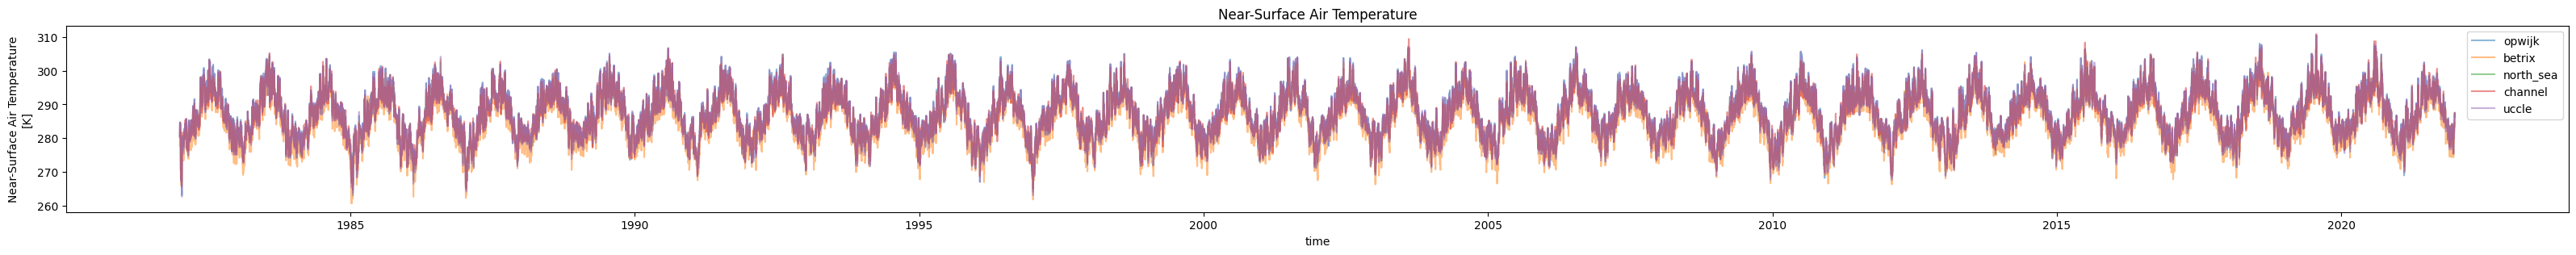

In [7]:
fig, ax = plt.subplots(figsize = (40,3))
d_da_point = {}
for i,point_id in enumerate(d_point_coords):
    point_coord = d_point_coords[point_id]
    da_point = select_point(ds, point_coord, rotated_pole=rotated_pole)
    d_da_point[point_id] = da_point

    da_point[variable].plot(ax=ax, label = point_id, alpha=0.5)
    ax.legend()
ax.set_title(da_eval.attrs['long_name'], loc='center')

In year 1982 we have 365 datapoints.
In year 1983 we have 365 datapoints.
In year 1984 we have 366 datapoints.
In year 1985 we have 365 datapoints.
In year 1986 we have 365 datapoints.
In year 1987 we have 365 datapoints.
In year 1988 we have 366 datapoints.
In year 1989 we have 365 datapoints.
In year 1990 we have 365 datapoints.
In year 1991 we have 365 datapoints.
In year 1992 we have 366 datapoints.
In year 1993 we have 365 datapoints.
In year 1994 we have 365 datapoints.
In year 1995 we have 365 datapoints.
In year 1996 we have 366 datapoints.
In year 1997 we have 365 datapoints.
In year 1998 we have 365 datapoints.
In year 1999 we have 365 datapoints.
In year 2000 we have 366 datapoints.
In year 2001 we have 365 datapoints.
In year 2002 we have 365 datapoints.
In year 2003 we have 365 datapoints.
In year 2004 we have 366 datapoints.
In year 2005 we have 365 datapoints.
In year 2006 we have 365 datapoints.
In year 2007 we have 365 datapoints.
In year 2008 we have 366 datapoints.
I

/tmp/ipykernel_3351993/3181561116.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right', fontsize='small', ncol=2)  # Adjust legend


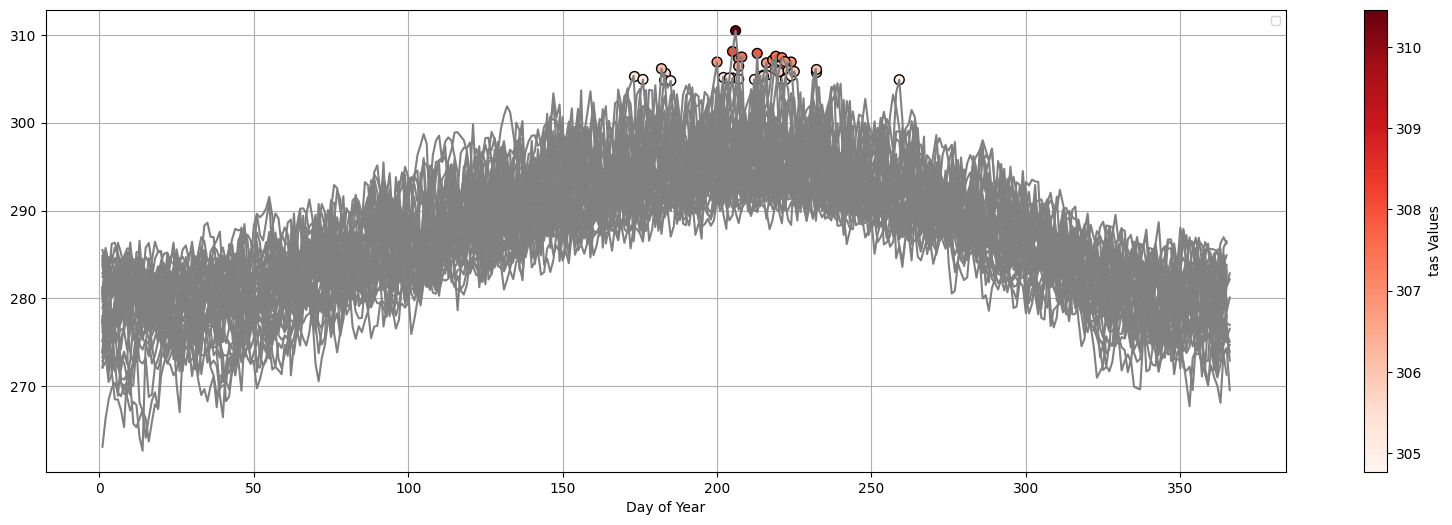

,time,tas,date,doy,year
35,1983-07-31 11:00:00,304.928079,1983-07-31,212,1983
31,1989-07-22 11:00:00,305.029050,1989-07-22,203,1989
23,1990-08-03 11:00:00,305.386593,1990-08-03,215,1990
12,1990-08-04 11:00:00,306.796845,1990-08-04,216,1990
34,1992-08-08 11:00:00,304.944527,1992-08-08,221,1992
30,1994-07-24 11:00:00,305.077807,1994-07-24,205,1994
22,1994-08-04 11:00:00,305.405119,1994-08-04,216,1994
28,1995-07-21 11:00:00,305.210907,1995-07-21,202,1995
32,1998-08-10 11:00:00,305.019325,1998-08-10,222,1998
7,2003-08-06 11:00:00,307.121213,2003-08-06,218,2003


In [8]:
highlight_extremes(da_serie = da_point, variable = variable, x = 40)

## Specific heatwave study

In [9]:
import numpy as np
import xarray as xr
import pandas as pd

def get_heatwaves(da: xr.DataArray, variable: str, definition='rmi') -> xr.DataArray:
    """
    Detects heatwave occurrences in a time series dataset.

    Parameters:
        da (xarray.DataArray): Dataset containing time and temperature variable (in Kelvin).
        variable (str): The name of the temperature variable in the dataset.
        definition (str): Heatwave definition to use ('rmi' or 'wmo').

    Returns:
        xr.DataArray: Boolean DataArray with the same time dimension, indicating heatwave days.
    """
    if definition == "rmi":

        # Define temperature thresholds (Kelvin)
        T1 = 298.15  # 25°C in Kelvin
        T2 = 303.15  # 30°C in Kelvin

        # Identify days above thresholds
        above_T1 = da[variable] > T1
        above_T2 = da[variable] > T2

        # Convert boolean arrays to integers for easier computation
        above_T1 = above_T1.astype(int)
        above_T2 = above_T2.astype(int)

        # Rolling sum to find consecutive days criteria
        rolling_T1 = above_T1.rolling(time=5, center=False).sum()
        rolling_T2 = above_T2.rolling(time=5, center=False).sum()

        # Condition: At least 5 consecutive days > 25°C and at least 3 of those days > 30°C
        heatwave_condition = (rolling_T1 >= 5) & (rolling_T2 >= 3)

    # Create a DataArray indicating heatwave days
    heatwave_days = heatwave_condition.reindex_like(da[variable], method="nearest")

    return heatwave_days


In [10]:
def get_heatwaves(da, variable, definition = "wmo"):

    df = da.to_dataframe().reset_index()
    df = df[["time", variable]]
    df = df.drop_duplicates().reset_index(drop = True)

    if definition == 'wmo':
        T = np.percentile(df[variable], 95)

        HW_prealloc =  pd.DataFrame(np.zeros([np.shape(df)[0],3]), columns = ["above_T","Length", "true_HW"])

        # Combining datasets
        df = pd.concat([df,
                        HW_prealloc], axis = 1)

        
        df['above_T'] = (df[variable] > T).astype(int)
        df["Length"] = df['above_T'].rolling(window=3, center=False).sum()

        indx_hw = np.where(df["Length"] == 3)[0]
        df["true_HW"].loc[indx_hw] = True

        hw = np.where(df["true_HW"] == True)

        add_days = pd.DataFrame(np.zeros([len(indx_hw),2]), columns = ["time", "add_days"])
        add_days["time"] = df["time"].loc[indx_hw].reset_index(drop = True)
        for i in np.arange(0, len(indx_hw)):
            c_day = indx_hw[i]
            p_day = indx_hw[i]-1
            p_hw_day = indx_hw[i-1]
            if p_day == p_hw_day:
                add_days["add_days"].loc[i] = add_days["add_days"].loc[i-1] + 1
        


        df = df.merge(add_days, how = 'left')
        df["Length"] = df["Length"] + df["add_days"]

        indx_hw = np.where(df["Length"] == 3)[0]
        indx_hw2 = indx_hw-1
        # indx_hw2 = np.where(df["above_T"].loc[indx_hw2] == 1, np.nan(df["Length"].loc[indx_hw2]))

        df["true_HW"].loc[indx_hw2] = True
        df["Length"].loc[indx_hw2] = 2.0
        indx_hw3 = indx_hw-2
        df["true_HW"].loc[indx_hw3] = True
        df["Length"].loc[indx_hw3] = 1.0

        df = df.drop(columns = ["add_days"])

        return [df, T]


    elif definition == "rmi":

        # Define temperature thresholds (Kelvin)
        T1 = 298.15  # 25°C in Kelvin
        T2 = 303.15  # 30°C in Kelvin

        HW_prealloc =  pd.DataFrame(np.zeros([np.shape(df)[0],5]), columns = ["above_T1",'above_T2', "Length1", "Length2","true_HW"])

        # Combining datasets
        df = pd.concat([df,
                        HW_prealloc], axis = 1)

        # Identify days above thresholds
        df["above_T1"] = df[variable] > T1
        df["above_T2"] = df[variable] > T2

        # Rolling sum to find consecutive days criteria
        df["Length1"] =  df["above_T1"].rolling(window=5, center=False).sum()
        df["Length2"] = df["above_T2"].rolling(window=5, center=False).sum()

        # Condition: At least 5 consecutive days > 25°C and at least 3 of those days > 30°C
        heatwave_condition = (df["Length1"] >= 5) & (df["Length2"] >= 3)

        # Create a DataArray indicating heatwave days
        df["true_HW"] = heatwave_condition.reindex_like(df[variable], method="nearest")

        return [df, T1, T2]
    


In [11]:
def get_HW_statistics(df, T1, T2 = None, variable = "T_2M"):
    indx_hw = np.where(df["true_HW"] == True)[0]
    df_hw = df.loc[indx_hw].reset_index(drop = True)
    indx_start_hw = np.where(np.logical_and(df_hw["Length"] == 1, df_hw["true_HW"] == True))[0]

    df_hw_overview = pd.DataFrame(np.zeros([len(indx_start_hw),6]), columns = ["start_day","end_day", "Length", "avg_T", "max_T", "anomaly_T"])
    for i in np.arange(0,len(indx_start_hw)):
        if i + 1 == len(indx_start_hw):
            hw_indx = np.arange(indx_start_hw[i],len(df_hw))
        
        elif i < len(indx_start_hw):
            hw_indx = np.arange(indx_start_hw[i],indx_start_hw[i+1])

        temp_hw = df_hw.loc[hw_indx]
        temp_hw = temp_hw.reset_index(drop=True)
        df_hw_overview["start_day"].loc[i] = pd.to_datetime(temp_hw["time"].iloc[0])
        df_hw_overview["end_day"].loc[i] = pd.to_datetime(temp_hw["time"].iloc[-1])
        df_hw_overview["Length"].loc[i] = temp_hw["Length"].iloc[-1]
        df_hw_overview["avg_T"].loc[i] = np.mean(temp_hw[variable])
        df_hw_overview["max_T"].loc[i] = np.max(temp_hw[variable])
        df_hw_overview["anomaly_T"].loc[i] = df_hw_overview["avg_T"].loc[i] - T1

    return df_hw_overview

In [12]:
[df, T1] = get_heatwaves(da_point, variable, definition = "wmo")

/tmp/ipykernel_3351993/1287674772.py:21: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["true_HW"].loc[indx_hw] = True
/tmp/ipykernel_3351993/1287674772.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [13]:
df

,time,tas,above_T,Length,true_HW
0,1982-01-01 11:00:00,280.205069,0,NaN,0.0
1,1982-01-02 11:00:00,284.244539,0,NaN,0.0
2,1982-01-03 11:00:00,284.302979,0,NaN,0.0
3,1982-01-04 11:00:00,284.403274,0,NaN,0.0
4,1982-01-05 11:00:00,283.039410,0,NaN,0.0
...,...,...,...,...,...
14605,2021-12-27 11:00:00,283.093334,0,NaN,0.0
14606,2021-12-28 11:00:00,283.819803,0,NaN,0.0
14607,2021-12-29 11:00:00,286.252754,0,NaN,0.0
14608,2021-12-30 11:00:00,286.973910,0,NaN,0.0


In [14]:
df_hw_overview = get_HW_statistics(df, T1, variable = variable)


/tmp/ipykernel_3351993/3757379712.py:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_hw_overview["start_day"].loc[i] = pd.to_datetime(temp_hw["time"].iloc[0])
/tmp/ipykernel_3351993/3757379712.py:16: FutureWarning: Setting an item of in

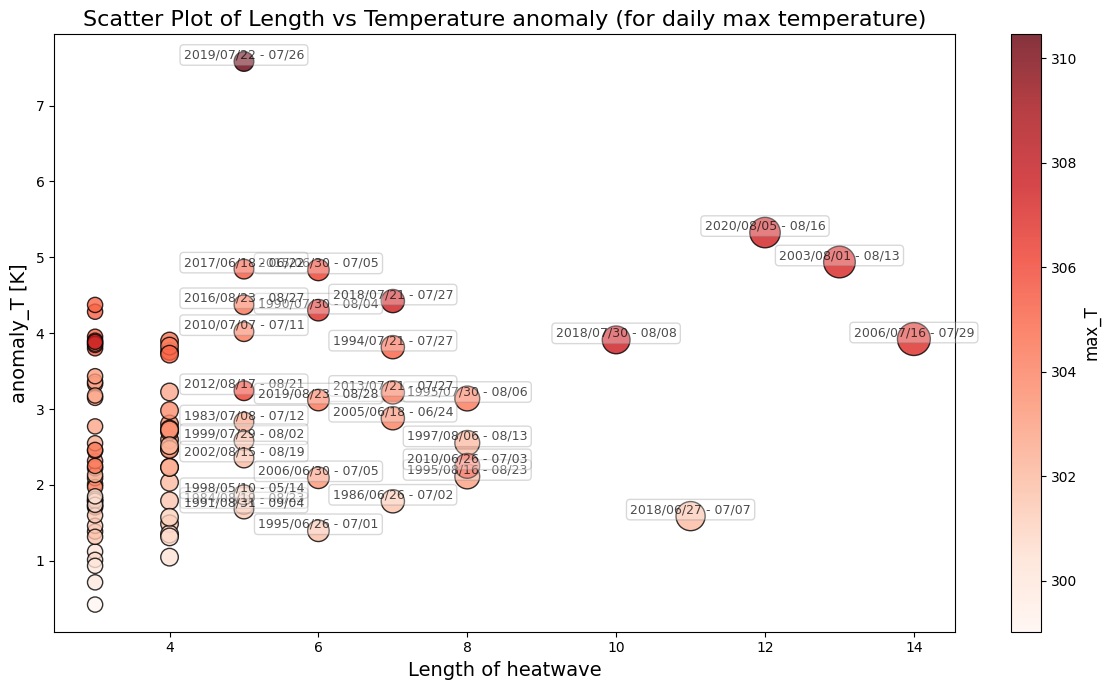

In [15]:

plt.figure(figsize=(12, 7))

# Normalize max_T for color mapping
norm = plt.Normalize(df_hw_overview['max_T'].min(), df_hw_overview['max_T'].max())
colors = plt.cm.Reds(norm(df_hw_overview['max_T']))

# Scatter plot with exponential scaling for size
scatter = plt.scatter(
    x=df_hw_overview['Length'], 
    y=df_hw_overview['anomaly_T'], 
    s=df_hw_overview['Length']*40,  # Exponential scaling for size
    c=df_hw_overview['max_T'], 
    cmap='Reds', 
    edgecolor='black',
    alpha=0.8
)

# Annotate each point with the start_day-end_day string (conditional labels)
for i, row in df_hw_overview.iterrows():
    if row['Length'] > 4 and row['max_T'] > 300:
        label = f"{row['start_day'].strftime('%Y/%m/%d')} - {row['end_day'].strftime('%m/%d')}"
        plt.text(
            row['Length'], row['anomaly_T'], label,
            fontsize=9, ha='center', va='bottom', color='black', alpha=0.7,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor="gray", facecolor="white", alpha=0.3)
        )

# Add colorbar for the max_T values
cbar = plt.colorbar(scatter)
cbar.set_label('max_T', fontsize=12)

# Add labels and title
plt.xlabel('Length of heatwave', fontsize=14)
plt.ylabel('anomaly_T [K]', fontsize=14)
plt.title('Scatter Plot of Length vs Temperature anomaly (for '+ frequency + ' ' + freq_statistic +' temperature)', fontsize=16)

# Show plot
plt.tight_layout()
plt.show()
